In [4]:
import os
import polars as pl
from dataclasses import dataclass

PROJECT_PATH = "/data1/datasets_1/human_cistrome/chip-atlas/peak_calls/tfbinding_scripts/tf-binding"

@dataclass
class SampleConfig:
    label: str
    sample: str
    ground_truth_file: str

# create a list of SampleConfig objects
sample_configs = [
    SampleConfig(label="AR", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/AR/merged/22RV1_AR_merged.bed"),
    SampleConfig(label="FOXA1", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/FOXA1/merged/22RV1_FOXA1_merged.bed"),
    SampleConfig(label="CTCF", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/CTCF/merged/22RV1_CTCF_merged.bed"),
    SampleConfig(label="POU5F1", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/POU5F1/merged/22RV1_POU5F1_merged.bed"),
    SampleConfig(label="MYC", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/MYC/merged/22RV1_MYC_merged.bed"),
    SampleConfig(label="MAX", sample="22Rv1", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/MAX/merged/22RV1_MAX_merged.bed"),
    # SampleConfig(label="NR3C1-HELA", sample="HELA", ground_truth_file=f"{PROJECT_PATH}/data/transcription_factors/NR3C1/merged/HELA_NR3C1_merged.bed")
]

In [5]:
import tempfile
import subprocess
def intersect_bed_files(main_df: pl.DataFrame, intersect_df: pl.DataFrame, region_type: str = None) -> pl.DataFrame:
    """
    Intersect two BED files using bedtools and return the original DataFrame with overlap flags.
    
    Args:
        main_df: Primary Polars DataFrame with BED data
        intersect_df: Secondary Polars DataFrame to intersect with
        region_type: Optional region type label to add to results
        
    Returns:
        Original DataFrame with additional column indicating overlaps
    """
    with tempfile.NamedTemporaryFile(delete=False, mode='w') as main_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as intersect_file, \
         tempfile.NamedTemporaryFile(delete=False, mode='w') as result_file:
        
        main_path = main_file.name
        intersect_path = intersect_file.name
        result_path = result_file.name

        # Write DataFrames to temporary files
        main_df.write_csv(main_path, separator="\t", include_header=False)
        intersect_df.write_csv(intersect_path, separator="\t", include_header=False)

        # Run bedtools intersect with -c flag to count overlaps
        command = f"bedtools intersect -a {main_path} -b {intersect_path} -c > {result_path}"
        subprocess.run(command, shell=True, check=True)

        # Read results back into Polars DataFrame
        result_df = pl.read_csv(
            result_path,
            separator="\t",
            has_header=False,
            new_columns=[*main_df.columns, "overlap_count"]
        )

    # Clean up temporary files
    os.remove(main_path)
    os.remove(intersect_path) 
    os.remove(result_path)

    # Add boolean overlap column
    result_df = result_df.with_columns(
        pl.col("overlap_count").gt(0).alias("overlaps_ground_truth")
    ).drop("overlap_count")

    return result_df


In [6]:
# Add dfs to list
HIGH_COUNT_QUANTILE = 0.5
MAX_COUNT_THRESHOLD = 30
MID_COUNT_THRESHOLD = 10


def threshold_peaks(df):
    max_count = df.select(pl.col("count").max()).item()
    
    if max_count <= 2:
        return df
    elif max_count > MAX_COUNT_THRESHOLD:
        threshold = df.select(pl.col("count").quantile(HIGH_COUNT_QUANTILE)).item()
        df = df.filter(pl.col("count") > threshold)
    elif max_count > MID_COUNT_THRESHOLD:
        threshold = df.select(pl.col("count").median()).item()
        df = df.filter(pl.col("count") > threshold)
    return df

dfs = []
for sample_config in sample_configs:
    parquet_path = PROJECT_PATH + "/data/processed_results/" + sample_config.label + "_" + sample_config.sample + "_processed.parquet"
    # print(parquet_path)
    df = pl.read_parquet(parquet_path, columns=["chr_name", "start", "end", "cell_line", "targets", "predicted", "weights", "probabilities"])
    df = df.rename({"chr_name": "chr"})
    chip_data = pl.read_csv(sample_config.ground_truth_file, separator="\t", has_header=False, new_columns=["chr", "start", "end", "count"])
    chip_data = threshold_peaks(chip_data)
    intersected_df = intersect_bed_files(df[["chr", "start", "end"]], chip_data)
    ground_truth_df = df.join(intersected_df, on=["chr", "start", "end"], how="left")
    ground_truth_df = ground_truth_df.with_columns(pl.when(pl.col("overlaps_ground_truth")).then(1).otherwise(0).alias("targets"))
    ground_truth_df = ground_truth_df.drop("overlaps_ground_truth")
    dfs.append(ground_truth_df)

dfs[0]


chr,start,end,cell_line,targets,predicted,weights,probabilities
str,i64,i64,str,i32,f64,f64,f64
"""chr8""",37573151,37573540,"""22Rv1""",0,0.0,-1.0,0.000037
"""chr8""",133171276,133171803,"""22Rv1""",0,0.0,-1.0,0.000491
"""chr7""",47548049,47548463,"""22Rv1""",0,0.0,-1.0,0.000054
"""chr22""",48497772,48498172,"""22Rv1""",0,0.0,-1.0,0.000271
"""chr16""",11676447,11677626,"""22Rv1""",0,0.0,-1.0,0.000252
…,…,…,…,…,…,…,…
"""chr3""",115072575,115072962,"""22Rv1""",0,0.0,-1.0,0.24669
"""chr5""",5497296,5497687,"""22Rv1""",0,0.0,-1.0,0.005839
"""chr13""",110593391,110594049,"""22Rv1""",0,0.0,-1.0,0.071762



Performance Metrics:
----------------------------------------------------------------------------------------------------
Dataset                   Threshold  F1 Score   ROC AUC    PR AUC    
----------------------------------------------------------------------------------------------------
AR (22Rv1)                0.962     0.623     0.928     0.664
FOXA1 (22Rv1)             0.944     0.761     0.918     0.841
CTCF (22Rv1)              0.998     0.868     0.982     0.930
POU5F1 (22Rv1)            0.524     0.554     0.882     0.469
MYC (22Rv1)               0.986     0.810     0.977     0.875
MAX (22Rv1)               0.991     0.844     0.981     0.918


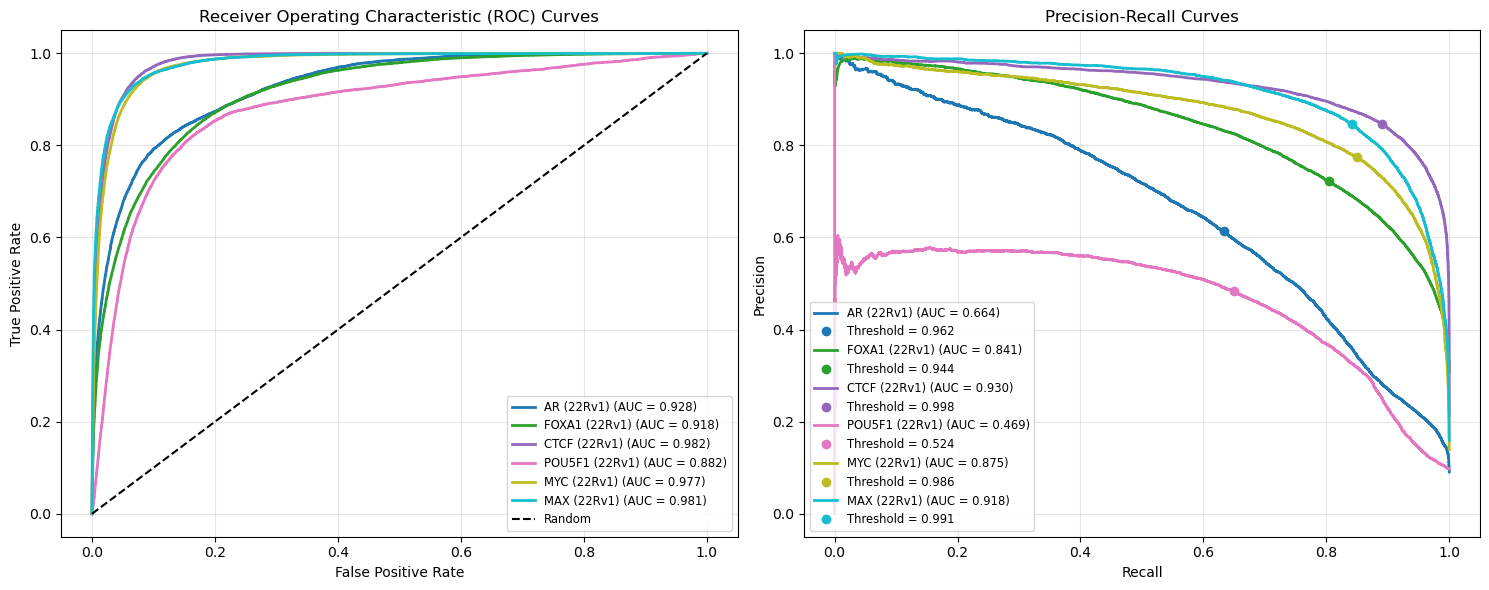


Confusion Matrix Metrics:
--------------------------------------------------------------------------------------------------------------------------------------------
Dataset                   Threshold  True Negative   False Positive  False Negative  True Positive   Total      Accuracy  
--------------------------------------------------------------------------------------------------------------------------------------------
AR (22Rv1)                    0.962           89900            3732            3416            5914     102962     0.931
FOXA1 (22Rv1)                 0.944           61411            9812            6231           25508     102962     0.844
CTCF (22Rv1)                  0.998           77433            3548            2390           19591     102962     0.942
POU5F1 (22Rv1)                0.524           86066            6914            3502            6480     102962     0.899
MYC (22Rv1)                   0.986           85073            3543            2161 

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

def ensure_numpy(arr):
    """Convert input to numpy array if it isn't already."""
    return np.array(arr) if not isinstance(arr, np.ndarray) else arr

def find_best_f1_threshold(y_true, y_score):
    """Find the optimal threshold that gives the best F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    return best_threshold, f1_scores[best_idx]

def get_display_name(config):
    """Get display name based on sample and label if available."""
    return f"{config.label} ({config.sample})" if hasattr(config, 'label') and config.label else config.sample

def print_confusion_metrics(dfs, sample_configs, threshold=None):
    """
    Print confusion matrix metrics for multiple datasets.
    
    Args:
        dfs: List of dataframes containing targets and probabilities
        sample_configs: List of sample configurations for labeling
        threshold: Optional fixed threshold to use. If None, finds best F1 threshold
    """
    print("\nConfusion Matrix Metrics:")
    print("-" * 140)
    headers = ["Dataset", "Threshold", "True Negative", "False Positive", "False Negative", "True Positive", "Total", "Accuracy"]
    print(f"{headers[0]:<25} {headers[1]:<10} {headers[2]:<15} {headers[3]:<15} {headers[4]:<15} {headers[5]:<15} {headers[6]:<10} {headers[7]:<10}")
    print("-" * 140)
    
    for df, config in zip(dfs, sample_configs):
        y_true = ensure_numpy(df["targets"])
        y_score = ensure_numpy(df["probabilities"])
        
        # Determine threshold
        if threshold is None:
            best_threshold, _ = find_best_f1_threshold(y_true, y_score)
            used_threshold = best_threshold
        else:
            used_threshold = threshold
        
        # Get predictions using threshold
        y_pred = (y_score >= used_threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        total = tn + fp + fn + tp
        accuracy = (tp + tn) / total
        
        display_name = get_display_name(config)
        print(f"{display_name:<25} {used_threshold:>9.3f} {tn:>15} {fp:>15} {fn:>15} {tp:>15} {total:>10} {accuracy:>9.3f}")
    
    print("-" * 140)

def plot_performance_curves(dfs, sample_configs, threshold=None):
    """
    Plot ROC and PR curves for multiple datasets side by side.
    
    Args:
        dfs: List of dataframes containing targets and probabilities
        sample_configs: List of sample configurations for labeling
        threshold: Optional fixed threshold to use. If None, finds best F1 threshold
    """
    fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(15, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(dfs)))
    
    print("\nPerformance Metrics:")
    print("-" * 100)
    print(f"{'Dataset':<25} {'Threshold':<10} {'F1 Score':<10} {'ROC AUC':<10} {'PR AUC':<10}")
    print("-" * 100)
    
    for idx, (df, config, color) in enumerate(zip(dfs, sample_configs, colors)):
        y_true = ensure_numpy(df["targets"])
        y_score = ensure_numpy(df["probabilities"])
        display_name = get_display_name(config)
        
        # Determine threshold
        if threshold is None:
            best_threshold, _ = find_best_f1_threshold(y_true, y_score)
            used_threshold = best_threshold
        else:
            used_threshold = threshold
        
        # Get predictions for F1 score
        y_pred = (y_score >= used_threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        # ROC curve
        fpr, tpr, roc_thresholds = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        ax_roc.plot(fpr, tpr, color=color, lw=2,
                   label=f'{display_name} (AUC = {roc_auc:.3f})')
                   
        # Find and plot threshold point on ROC
        thresh_idx = np.argmin(np.abs(roc_thresholds - used_threshold))
        # ax_roc.plot(fpr[thresh_idx], tpr[thresh_idx], 'o', color=color,
        #            label=f'Threshold = {used_threshold:.3f}')
        
        # PR curve
        precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
        pr_auc = auc(recall, precision)
        
        # Plot PR curve
        ax_pr.plot(recall, precision, color=color, lw=2,
                  label=f'{display_name} (AUC = {pr_auc:.3f})')
                  
        # # Find and plot threshold point on PR
        # if len(pr_thresholds) > 0:  # Handle edge case
        #     thresh_idx = np.argmin(np.abs(pr_thresholds - used_threshold))
        #     if thresh_idx < len(recall):  # Ensure index is valid
        #         ax_pr.plot(recall[thresh_idx], precision[thresh_idx], 'o', 
        #                  color=color,
        #                  label=f'Threshold = {used_threshold:.3f}')
        
        # Print metrics
        print(f"{display_name:<25} {used_threshold:.3f}     {f1:.3f}     "
              f"{roc_auc:.3f}     {pr_auc:.3f}")
    
    # ROC plot settings
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
    ax_roc.set_xlim([-0.05, 1.05])
    ax_roc.set_ylim([-0.05, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
    ax_roc.legend(loc='lower right', fontsize='small')
    ax_roc.grid(True, alpha=0.3)
    
    # PR plot settings
    ax_pr.set_xlim([-0.05, 1.05])
    ax_pr.set_ylim([-0.05, 1.05])
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title('Precision-Recall Curves')
    ax_pr.legend(loc='lower left', fontsize='small')
    ax_pr.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Use with fixed threshold can also do None for best F1 threshold
threshold = None
plot_performance_curves(dfs, sample_configs, threshold=threshold)
print_confusion_metrics(dfs, sample_configs, threshold=threshold)

In [8]:

# def bootstrap_metrics(y_true, y_score, threshold, n_iterations=1000, confidence=0.95):
#     """
#     Calculate confidence intervals for metrics using bootstrapping.
    
#     Args:
#         y_true: True binary labels
#         y_score: Predicted probabilities
#         threshold: Classification threshold
#         n_iterations: Number of bootstrap iterations
#         confidence: Confidence level (default: 0.95 for 95% confidence)
    
#     Returns:
#         Dictionary with metric names as keys and tuples (lower, median, upper) as values
#     """
#     # Convert inputs to numpy arrays
#     y_true = np.array(y_true)
#     y_score = np.array(y_score)
    
#     # Initialize storage for bootstrap results
#     bootstrap_results = {
#         'f1': [],
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'roc_auc': [],
#         'pr_auc': []
#     }
    
#     # Calculate indices for confidence intervals
#     alpha = (1 - confidence) / 2
#     lower_idx = int(alpha * n_iterations)
#     upper_idx = int((1 - alpha) * n_iterations)
    
#     # Perform bootstrapping
#     for _ in range(n_iterations):
#         # Sample with replacement
#         indices = np.random.choice(len(y_true), len(y_true), replace=True)
#         boot_y_true = y_true[indices]
#         boot_y_score = y_score[indices]
        
#         # Binary predictions using threshold
#         boot_y_pred = (boot_y_score >= threshold).astype(int)
        
#         # Calculate metrics
#         bootstrap_results['f1'].append(f1_score(boot_y_true, boot_y_pred))
#         bootstrap_results['accuracy'].append(accuracy_score(boot_y_true, boot_y_pred))
#         bootstrap_results['precision'].append(precision_score(boot_y_true, boot_y_pred))
#         bootstrap_results['recall'].append(recall_score(boot_y_true, boot_y_pred))
        
#         # ROC AUC 
#         if len(np.unique(boot_y_true)) > 1:  # Only if we have both classes
#             bootstrap_results['roc_auc'].append(roc_auc_score(boot_y_true, boot_y_score))
        
#         # PR AUC calculation
#         precision_values, recall_values, _ = precision_recall_curve(boot_y_true, boot_y_score)
#         bootstrap_results['pr_auc'].append(auc(recall_values, precision_values))
    
#     # Sort the results and get confidence intervals
#     result_intervals = {}
#     for metric, values in bootstrap_results.items():
#         sorted_values = sorted(values)
#         result_intervals[metric] = (
#             sorted_values[lower_idx],  # Lower bound
#             np.median(sorted_values),  # Median
#             sorted_values[upper_idx]   # Upper bound
#         )
    
#     return result_intervals

# def print_performance_metrics_with_ci(dfs, sample_configs, threshold=None):
#     """
#     Print performance metrics with confidence intervals for each dataset.
    
#     Args:
#         dfs: List of dataframes containing targets and probabilities
#         sample_configs: List of sample configurations for labeling
#         threshold: Optional fixed threshold to use. If None, finds best F1 threshold
#     """
#     print("\nPerformance Metrics with 95% Confidence Intervals:")
#     print("-" * 120)
#     headers = ["Dataset", "Threshold", "F1 Score (95% CI)", "ROC AUC (95% CI)", "PR AUC (95% CI)"]
#     print(f"{headers[0]:<25} {headers[1]:<10} {headers[2]:<25} {headers[3]:<25} {headers[4]:<25}")
#     print("-" * 120)
    
#     for df, config in zip(dfs, sample_configs):
#         y_true = ensure_numpy(df["targets"])
#         y_score = ensure_numpy(df["probabilities"])
#         display_name = get_display_name(config)
        
#         # Determine threshold
#         if threshold is None:
#             best_threshold, _ = find_best_f1_threshold(y_true, y_score)
#             used_threshold = best_threshold
#         else:
#             used_threshold = threshold
        
#         # Get confidence intervals using bootstrapping
#         intervals = bootstrap_metrics(y_true, y_score, used_threshold)
        
#         # Format confidence intervals
#         f1_ci = f"{intervals['f1'][1]:.3f} ({intervals['f1'][0]:.3f}-{intervals['f1'][2]:.3f})"
#         roc_ci = f"{intervals['roc_auc'][1]:.3f} ({intervals['roc_auc'][0]:.3f}-{intervals['roc_auc'][2]:.3f})"
#         pr_ci = f"{intervals['pr_auc'][1]:.3f} ({intervals['pr_auc'][0]:.3f}-{intervals['pr_auc'][2]:.3f})"
        
#         print(f"{display_name:<25} {used_threshold:>9.3f} {f1_ci:<25} {roc_ci:<25} {pr_ci:<25}")
    
#     print("-" * 120)

# # Add this after the existing performance metrics calculations
# print_performance_metrics_with_ci(dfs, sample_configs, threshold=threshold)



In [9]:
# def bootstrap_metrics(y_true, y_score, threshold, n_iterations=1000, confidence=0.95, sample_percent=100):
#     """
#     Calculate confidence intervals for metrics using bootstrapping.
    
#     Args:
#         y_true: True binary labels
#         y_score: Predicted probabilities
#         threshold: Classification threshold
#         n_iterations: Number of bootstrap iterations
#         confidence: Confidence level (default: 0.95 for 95% confidence)
#         sample_percent: Percentage of original data to sample (default: 100%)
    
#     Returns:
#         Dictionary with metric names as keys and tuples (lower, median, upper) as values
#     """
#     # Convert inputs to numpy arrays
#     y_true = np.array(y_true)
#     y_score = np.array(y_score)
    
#     # Determine sample size based on percentage
#     bootstrap_sample_size = int(len(y_true) * sample_percent / 100)
    
#     # Initialize storage for bootstrap results
#     bootstrap_results = {
#         'f1': [],
#         'accuracy': [],
#         'precision': [],
#         'recall': [],
#         'roc_auc': [],
#         'pr_auc': []
#     }
    
#     # Calculate indices for confidence intervals
#     alpha = (1 - confidence) / 2
#     lower_idx = int(alpha * n_iterations)
#     upper_idx = int((1 - alpha) * n_iterations)
    
#     # Perform bootstrapping
#     for _ in range(n_iterations):
#         # Sample with replacement
#         indices = np.random.choice(len(y_true), bootstrap_sample_size, replace=True)
#         boot_y_true = y_true[indices]
#         boot_y_score = y_score[indices]
        
#         # Binary predictions using threshold
#         boot_y_pred = (boot_y_score >= threshold).astype(int)
        
#         # Calculate metrics
#         bootstrap_results['f1'].append(f1_score(boot_y_true, boot_y_pred))
#         bootstrap_results['accuracy'].append(accuracy_score(boot_y_true, boot_y_pred))
#         bootstrap_results['precision'].append(precision_score(boot_y_true, boot_y_pred))
#         bootstrap_results['recall'].append(recall_score(boot_y_true, boot_y_pred))
        
#         # ROC AUC 
#         if len(np.unique(boot_y_true)) > 1:  # Only if we have both classes
#             bootstrap_results['roc_auc'].append(roc_auc_score(boot_y_true, boot_y_score))
        
#         # PR AUC calculation
#         precision_values, recall_values, _ = precision_recall_curve(boot_y_true, boot_y_score)
#         bootstrap_results['pr_auc'].append(auc(recall_values, precision_values))
    
#     # Sort the results and get confidence intervals
#     result_intervals = {}
#     for metric, values in bootstrap_results.items():
#         sorted_values = sorted(values)
#         result_intervals[metric] = (
#             sorted_values[lower_idx],  # Lower bound
#             np.median(sorted_values),  # Median
#             sorted_values[upper_idx]   # Upper bound
#         )
    
#     return result_intervals
# def print_performance_metrics_with_ci(dfs, sample_configs, threshold=None, sample_percent=100):
#     """
#     Print performance metrics with confidence intervals for each dataset.
    
#     Args:
#         dfs: List of dataframes containing targets and probabilities
#         sample_configs: List of sample configurations for labeling
#         threshold: Optional fixed threshold to use. If None, finds best F1 threshold
#         sample_percent: Percentage of data for bootstrapping (default: 100%)
#     """
#     print("\nPerformance Metrics with 95% Confidence Intervals:")
#     print("-" * 120)
#     headers = ["Dataset", "Threshold", "F1 Score (95% CI)", "ROC AUC (95% CI)", "PR AUC (95% CI)"]
#     print(f"{headers[0]:<25} {headers[1]:<10} {headers[2]:<25} {headers[3]:<25} {headers[4]:<25}")
#     print("-" * 120)
    
#     for df, config in zip(dfs, sample_configs):
#         y_true = ensure_numpy(df["targets"])
#         y_score = ensure_numpy(df["probabilities"])
#         display_name = get_display_name(config)
        
#         # Determine threshold
#         if threshold is None:
#             best_threshold, _ = find_best_f1_threshold(y_true, y_score)
#             used_threshold = best_threshold
#         else:
#             used_threshold = threshold
        
#         # Get confidence intervals using bootstrapping
#         intervals = bootstrap_metrics(y_true, y_score, used_threshold, sample_percent=sample_percent)
        
#         # Format confidence intervals
#         f1_ci = f"{intervals['f1'][1]:.3f} ({intervals['f1'][0]:.3f}-{intervals['f1'][2]:.3f})"
#         roc_ci = f"{intervals['roc_auc'][1]:.3f} ({intervals['roc_auc'][0]:.3f}-{intervals['roc_auc'][2]:.3f})"
#         pr_ci = f"{intervals['pr_auc'][1]:.3f} ({intervals['pr_auc'][0]:.3f}-{intervals['pr_auc'][2]:.3f})"
        
#         print(f"{display_name:<25} {used_threshold:>9.3f} {f1_ci:<25} {roc_ci:<25} {pr_ci:<25}")
    
#     print("-" * 120)

#     # Add this after the existing performance metrics calculations
# print_performance_metrics_with_ci(dfs, sample_configs, threshold=threshold, sample_percent=5)

/tmp/ipykernel_37180/620360567.py:267: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_37180/620360567.py:267: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


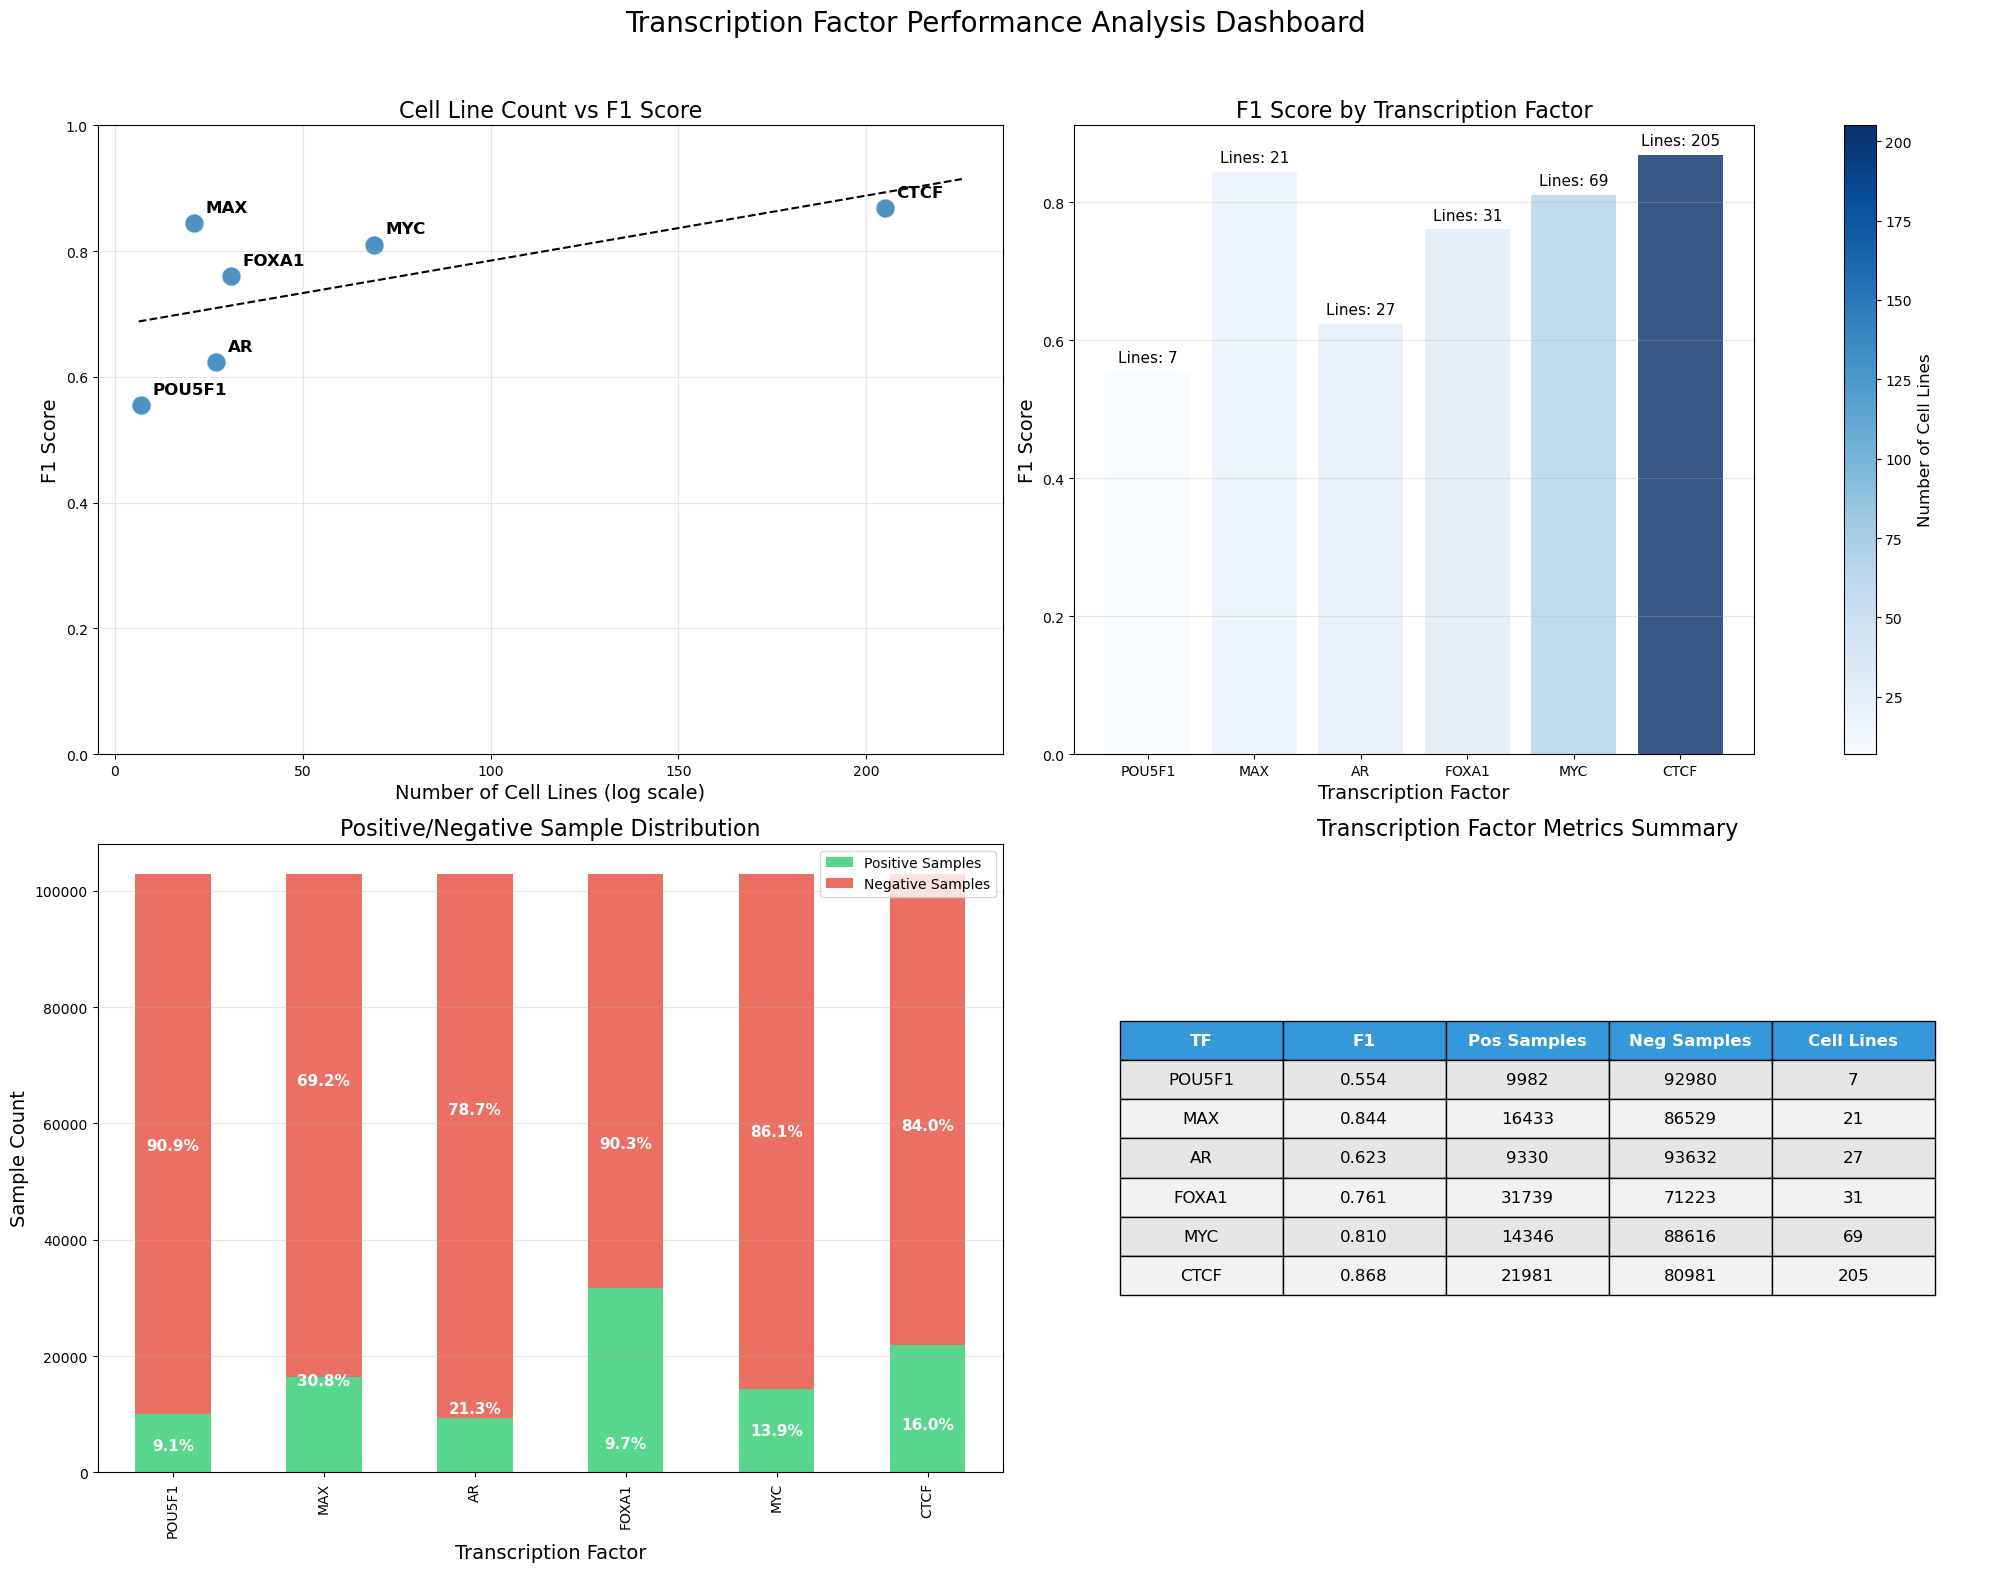

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from sklearn.metrics import precision_recall_curve, f1_score
import os
import json
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional
import seaborn as sns

# ============================================================
# Utility Functions
# ============================================================
def validate_file_exists(path: str) -> bool:
    """Check if a file exists."""
    return os.path.exists(path)

def validate_file_not_empty(path: str) -> bool:
    """
    Checks if a file exists and is not empty.
    
    Args:
        path: Path to the file to check
        
    Returns:
        True if the file exists and is not empty, False otherwise
    """
    return os.path.exists(path) and os.path.getsize(path) > 0

def get_cell_line_count(ground_truth_file: str, aligned_chip_data_dir: Optional[str] = None, 
                        cell_line_mapping: Optional[Dict[str, str]] = None) -> int:
    """
    Extract number of valid cell lines from directory structure,
    checking that both the files exist and have corresponding ATAC files.
    
    Args:
        ground_truth_file: Path to ground truth file
        aligned_chip_data_dir: Directory containing aligned ATAC data
        cell_line_mapping: Dictionary mapping cell line keys to cell line names
        
    Returns:
        Count of valid cell lines that have both files and ATAC data
    """
    directory = os.path.dirname(ground_truth_file)
    
    # Get all potential cell line files in the directory (excluding hidden files)
    cell_line_files = {
        f.split("_")[0]: os.path.join(directory, f) 
        for f in os.listdir(directory) 
        if not f.startswith('.') and f.endswith(".bed")
    }
    
    # If no ATAC validation is needed (no mapping or aligned dir provided)
    if not aligned_chip_data_dir or not cell_line_mapping:
        # Only count files that exist and are not empty
        valid_cell_lines = sum(1 for f in cell_line_files.values() 
                              if validate_file_not_empty(f))
        return valid_cell_lines
    
    # Count valid cell lines with ATAC files
    valid_count = 0
    for cell_line_key, file_path in cell_line_files.items():
        # Skip if the file doesn't exist or is empty
        if not validate_file_not_empty(file_path):
            continue
            
        # Skip if cell line not in mapping
        if cell_line_key not in cell_line_mapping:
            continue
            
        # Check for corresponding ATAC file
        cell_line = cell_line_mapping[cell_line_key]
        atac_path = os.path.join(
            aligned_chip_data_dir, 
            cell_line, 
            "peaks", 
            f"{cell_line}.filtered.broadPeak"
        )
        
        # Count only if ATAC file exists and is not empty
        if validate_file_not_empty(atac_path):
            valid_count += 1
    
    return valid_count

def find_best_f1_threshold(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float]:
    """Find the threshold that gives the best F1 score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
    return best_threshold, f1_scores[best_idx]

def calculate_metrics_by_tf(sample_configs: List, dfs: List[pl.DataFrame], 
                           aligned_chip_data_dir: Optional[str] = None,
                           cell_line_mapping: Optional[Dict[str, str]] = None) -> pl.DataFrame:
    """
    Calculate metrics for each transcription factor.
    
    Args:
        sample_configs: List of SampleConfig objects
        dfs: List of corresponding DataFrames with predictions
        aligned_chip_data_dir: Directory with aligned ATAC data
        cell_line_mapping: Dictionary mapping cell line keys to names
        
    Returns:
        Polars DataFrame with TF, cell_line_count, and f1_score
    """
    results = []
    
    for config, df in zip(sample_configs, dfs):
        # Get true labels and predictions
        y_true = np.array(df["targets"])
        y_score = np.array(df["probabilities"])
        
        # Find best threshold for F1 score
        best_threshold, _ = find_best_f1_threshold(y_true, y_score)
        
        # Calculate F1 score using best threshold
        y_pred = (y_score >= best_threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        # Count valid cell lines with ATAC validation
        cell_line_count = get_cell_line_count(
            config.ground_truth_file,
            aligned_chip_data_dir,
            cell_line_mapping
        )
        
        # Add to results
        results.append({
            "transcription_factor": config.label,
            "cell_line": config.sample,
            "cell_line_count": cell_line_count,
            "f1_score": f1,
            "positive_count": df.filter(pl.col("targets") == 1).height,
            "negative_count": df.filter(pl.col("targets") == 0).height,
            "total_count": df.height
        })
    
    # Convert to Polars DataFrame
    return pl.from_dicts(results)

def plot_tf_metrics(metrics_df: pl.DataFrame, save_path: Optional[str] = None) -> None:
    """
    Create visualizations showing relationship between cell line count and F1 score.
    
    Args:
        metrics_df: Polars DataFrame with metrics data
        save_path: Optional path to save the plot
    """
    # Convert to pandas for easier plotting with seaborn
    pdf = metrics_df.to_pandas()
    
    # Sort the dataframe by cell_line_count for the bar chart
    pdf_sorted = pdf.sort_values('cell_line_count')
    
    # Set up the figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Create a colormap based on cell line count - from light to dark
    norm = plt.Normalize(pdf['cell_line_count'].min(), pdf['cell_line_count'].max())
    cmap = plt.cm.Blues  # Use Blues colormap which goes from light to dark
    colors = cmap(norm(pdf['cell_line_count']))
    colors_sorted = cmap(norm(pdf_sorted['cell_line_count']))
    
    # Plot 1: Cell Line Count vs F1 Score
    sns.scatterplot(
        x="cell_line_count", 
        y="f1_score", 
        data=pdf, 
        s=150, 
        alpha=0.8, 
        palette=colors,
        ax=axes[0]
    )
    
    # Add a linear trend line through the points
    x_data = pdf['cell_line_count']
    y_data = pdf['f1_score']
    # Calculate linear fit coefficients (using linear scale)
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    # Create x range for line (using linear scale)
    x_min, x_max = x_data.min() * 0.9, x_data.max() * 1.1
    x_range = np.linspace(x_min, x_max, 100)
    # Plot the trend line
    axes[0].plot(x_range, p(x_range), '--', color='black', linewidth=1.5)
    
    # Add labels for each point
    for i, row in pdf.iterrows():
        axes[0].annotate(
            row['transcription_factor'], 
            (row['cell_line_count'], row['f1_score']),
            xytext=(7, 7), 
            textcoords='offset points',
            fontsize=11,
            fontweight='bold'
        )
    
    # F1 score range (without log scale on x-axis)
    axes[0].set_ylim([0, 1])
    
    axes[0].set_xlabel('Number of Cell Lines (log scale)', fontsize=12)
    axes[0].set_ylabel('F1 Score', fontsize=12)
    axes[0].set_title('Relationship Between Number of Cell Lines and F1 Score', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Bar chart comparing F1 scores
    bar_colors = colors
    bars = axes[1].bar(
        pdf['transcription_factor'], 
        pdf['f1_score'], 
        alpha=0.8,
        color=bar_colors
    )
    
    # Add cell line count as text on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.01,
            f'Lines: {pdf.iloc[i]["cell_line_count"]}',
            ha='center', 
            va='bottom',
            fontsize=10
        )
    
    axes[1].set_xlabel('Transcription Factor', fontsize=12)
    axes[1].set_ylabel('F1 Score', fontsize=12)
    axes[1].set_title('F1 Score by Transcription Factor', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_tf_metrics_detailed(metrics_df: pl.DataFrame, save_path: Optional[str] = None) -> None:
    """
    Create a detailed dashboard of transcription factor metrics.
    
    Args:
        metrics_df: Polars DataFrame with metrics data
        save_path: Optional path to save the plot
    """
    # Convert to pandas for easier plotting with seaborn
    pdf = metrics_df.to_pandas()
    
    # Sort the dataframe by cell_line_count for the bar chart
    pdf_sorted = pdf.sort_values('cell_line_count')
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    plt.subplots_adjust(hspace=0.3)
    
    # Create a colormap based on cell line count - from light to dark
    norm = plt.Normalize(pdf['cell_line_count'].min(), pdf['cell_line_count'].max())
    cmap = plt.cm.Blues  # Use Blues colormap which goes from light to dark
    colors = cmap(norm(pdf['cell_line_count']))
    colors_sorted = cmap(norm(pdf_sorted['cell_line_count']))
    
    # Plot 1: Cell Line Count vs F1 Score (top left)
    sns.scatterplot(
        x="cell_line_count", 
        y="f1_score", 
        data=pdf, 
        s=200, 
        alpha=0.8, 
        palette=colors,
        ax=axes[0, 0]
    )
    
    # Add a linear trend line through the points
    x_data = pdf['cell_line_count']
    y_data = pdf['f1_score']
    # Calculate linear fit coefficients (using linear scale)
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    # Create x range for line (using linear scale)
    x_min, x_max = x_data.min() * 0.9, x_data.max() * 1.1
    x_range = np.linspace(x_min, x_max, 100)
    # Plot the trend line
    axes[0, 0].plot(x_range, p(x_range), '--', color='black', linewidth=1.5)
    
    # Add labels for each point
    for i, row in pdf.iterrows():
        axes[0, 0].annotate(
            row['transcription_factor'], 
            (row['cell_line_count'], row['f1_score']),
            xytext=(8, 8), 
            textcoords='offset points',
            fontsize=12,
            fontweight='bold'
        )
    
    # F1 score range (without log scale on x-axis)
    axes[0, 0].set_ylim([0, 1])
    
    axes[0, 0].set_xlabel('Number of Cell Lines (log scale)', fontsize=14)
    axes[0, 0].set_ylabel('F1 Score', fontsize=14)
    axes[0, 0].set_title('Cell Line Count vs F1 Score', fontsize=16)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Bar chart comparing F1 scores ordered by cell line count (top right)
    bars = axes[0, 1].bar(
        pdf_sorted['transcription_factor'], 
        pdf_sorted['f1_score'], 
        alpha=0.8,
        color=colors_sorted
    )
    
    # Add cell line count as text on top of bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        axes[0, 1].text(
            bar.get_x() + bar.get_width()/2., 
            height + 0.01,
            f'Lines: {pdf_sorted.iloc[i]["cell_line_count"]}',
            ha='center', 
            va='bottom',
            fontsize=11
        )
    
    # Add a colorbar to show the relationship between color and cell line count
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[0, 1], orientation='vertical', pad=0.1)
    cbar.set_label('Number of Cell Lines', fontsize=12)
    
    axes[0, 1].set_xlabel('Transcription Factor', fontsize=14)
    axes[0, 1].set_ylabel('F1 Score', fontsize=14)
    axes[0, 1].set_title('F1 Score by Transcription Factor', fontsize=16)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Positive/Negative sample distribution (bottom left)
    # Sort by cell line count
    sorted_tfs = pdf_sorted['transcription_factor'].tolist()
    data_for_stacked = pdf.set_index('transcription_factor').loc[sorted_tfs][['positive_count', 'negative_count']]
    data_for_stacked.plot(
        kind='bar', 
        stacked=True, 
        ax=axes[1, 0],
        color=['#2ecc71', '#e74c3c'],
        alpha=0.8
    )
    
    # Add percentage text
    for i, tf in enumerate(pdf['transcription_factor']):
        pos = pdf.iloc[i]['positive_count']
        neg = pdf.iloc[i]['negative_count']
        total = pos + neg
        percent_pos = (pos / total) * 100
        
        # Add text for positive percentage
        axes[1, 0].text(
            i, 
            pos/2,
            f'{percent_pos:.1f}%',
            ha='center',
            va='center',
            fontsize=11,
            color='white',
            fontweight='bold'
        )
        
        # Add text for negative percentage
        axes[1, 0].text(
            i, 
            pos + neg/2,
            f'{100-percent_pos:.1f}%',
            ha='center',
            va='center',
            fontsize=11,
            color='white',
            fontweight='bold'
        )
    
    axes[1, 0].set_xlabel('Transcription Factor', fontsize=14)
    axes[1, 0].set_ylabel('Sample Count', fontsize=14)
    axes[1, 0].set_title('Positive/Negative Sample Distribution', fontsize=16)
    axes[1, 0].legend(['Positive Samples', 'Negative Samples'])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Metrics table (bottom right)
    # Remove the axis
    axes[1, 1].axis('off')
    
    # Create a table with sorted data
    table_data = [
        ['TF', 'F1', 'Pos Samples', 'Neg Samples', 'Cell Lines'],
    ]
    
    for i, row in pdf_sorted.iterrows():
        table_data.append([
            row['transcription_factor'],
            f"{row['f1_score']:.3f}",
            f"{row['positive_count']}",
            f"{row['negative_count']}",
            f"{row['cell_line_count']}"
        ])
    
    table = axes[1, 1].table(
        cellText=table_data,
        loc='center',
        cellLoc='center',
        colWidths=[0.18, 0.18, 0.18, 0.18, 0.18]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Style the header row
    for j in range(len(table_data[0])):
        cell = table[(0, j)]
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#3498db')
    
    # Alternate row colors for better readability
    for i in range(1, len(table_data)):
        for j in range(len(table_data[0])):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#f2f2f2')
            else:
                cell.set_facecolor('#e6e6e6')
    
    axes[1, 1].set_title('Transcription Factor Metrics Summary', fontsize=16)
    
    # Add a main title to the figure
    fig.suptitle('Transcription Factor Performance Analysis Dashboard', fontsize=20, y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for suptitle
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

metrics_df = calculate_metrics_by_tf(sample_configs, dfs)
# plot_tf_metrics(metrics_df)
plot_tf_metrics_detailed(metrics_df, save_path="tf_metrics_dashboard.png")

In [8]:
import os

def create_cell_line_mapping(tissue_to_cell_lines):
    """
    Create a mapping from cell line to tissue type.
    Inverts the tissue_to_cell_lines dictionary for easy lookup.
    
    Args:
        tissue_to_cell_lines: Dictionary with tissue as key and list of cell lines as value
        
    Returns:
        Dictionary mapping each cell line to its tissue type
    """
    cell_line_to_tissue = {}
    for tissue, cell_lines in tissue_to_cell_lines.items():
        for cell_line in cell_lines:
            cell_line_to_tissue[cell_line] = tissue
    return cell_line_to_tissue

# Define the tissue to cell lines mapping
tissueToStandardCellLines = {
    "Blood": ["697", "DOHH-2", "GM12878", "HL-60", "JURKAT", "K-562", "K562", 
              "KARPAS-299", "KASUMI-1", "KG-1", "KMS-11", "LP-1", "MEG-01", 
              "MM.1S", "MOLT-4", "MOLM-13", "MV-4-11", "NALM-6", "NAMALWA", 
              "OCI-AML3", "OCI-LY1", "OCI-LY3", "OCI-LY8", "OCI-My5", "OPM-2", 
              "REH", "RPMI_8226", "RS411", "SEM", "SU-DHL-6", "SUP-B15", 
              "THP-1", "U-266", "U-937", "Daudi", "Raji", "Ramos",
              "NB-4", "OCI-LY-7", "MUTZ-3", "KU812", "CUTLL1", "PER-117", 
              "DND-41", "T-ALL", "MOLT-14", "HPB-ALL", "CD20+", "LOUCY", 
              "CHRF-288-11", "EOL-1", "OCI-LY-3", "BCBL1", "P493-6", "GEN2.2", 
              "SU-DHL-5", "BLUE-1", "CA46", "BL-41", "HUDEP-1", "HUDEP-2", 
              "BLAER1", "UT-7", "BC-3"],
    
    "Kidney": ["HEK_293", "786-O", "TTC1240", "293", "RPTEC", "HRE", "HCFAA", 
               "NEPHRONS"],
    
    "Prostate": ["22Rv1", "42D", "42D-ENZR", "C4-2", "C42B", "DU145", "LNCAP", 
                "NCI-H660", "PC-3", "RWPE-1", "VCAP", "R1-AD1", "LAPC-4", 
                "C4-2B", "R1-D567", "CWR-R1", "CWR22PC", "LHSAR", "LUCAP",
                "RWPE-2", "PREC"],
    
    "Skin": ["A-375", "BJ", "BJ_hTERT", "SK-MEL-28", "SK-MEL-147", "KER-CT",
             "AG09319", "M-14", "NHEK", "AG10803", "HMS001"],
    
    "Lung": ["A549", "BEAS-2B", "CALU-3", "HCC827", "NCI-H128", "NCI-H1437", 
             "NCI-H1963", "NCI-H2107", "NCI-H2126", "NCI-H3122", "NCI-H441", 
             "NCI-H446", "NCI-H524", "NCI-H69", "NCI-H82", "NCI-H889", 
             "NCI-H929", "DMS53", "SAEC", "PC-9", "SHP-77", "NCI-H847", 
             "NCI-H1048", "NCI-H2171", "NCI-H211"],
    
    "CNS": ["A673", "KELLY", "NB69", "SH-SY5Y", "SK-N-AS", "SK-N-FI", 
            "SK-N-SH", "U-87_MG", "D283", "HAC", "BE(2)-C", "D54", 
            "SU-DIPG-IV", "HA-SP", "HBMEC", "NH-A", "MEDULLO", "GSC23", 
            "SH-EP", "D458", "ONS-76", "G-401", "IMR-5"],
    
    "Stomach": ["AGS", "MKN-45", "HGC-27"],
    
    "Breast": ["BT-549", "CAL_51", "CAMA-1", "HCC1954", "HCC70", "MCF-7", 
               "MCF_10A", "MDA-MB-134-VI", "MDA-MB-231", "MDA-MB-453", 
               "SK-BR-3", "SUM-159PT", "SUM44PE", "T-47D", "MFM-223",
               "FT282", "MCF10DCIS.COM", "MDA-MB-435", "MDA-MB-468", "UACC-812"],
    
    "Head_and_Neck": ["CAL_27", "Detroit_562", "FADU", "93-VU147T", "SCC090"],
    
    "Ovary": ["Caov-3", "OVCAR-3", "OVCAR-8", "SK-OV-3", "OAW42", "A2780",
              "HEY", "IOSE11", "IOSE4", "KURAMOCHI", "ES-2", "MCAS", "RMG-II",
              "UWB1.289", "JHOC-5", "EFO-27"],
    
    "Pancreas": ["Capan-1", "CFPAC-1", "PANC-1", "HPAF", "KP4", "ENDOC-BETAH3",
                 "ENDOC-H1"],
    
    "Colon": ["COLO_205", "COLO_320", "DLD-1", "GP5d", "HCT116", "HCT-15", 
              "HT29", "HT-29", "LS-180", "SW_620", "SW480", "CACO-2", "LOVO",
              "LS-174T"],
    
    "Endometrium": ["AN3_CA", "HEC-1-A", "HEC-1-B", "Ishikawa", "HEC-50B", 
                   "ECC-1", "EEC16"],
    
    "Aorta": ["HAEC", "AOAF"],
    
    "Cardiovascular": ["HCASMC", "HCM"],
    
    "Cervix": ["HELA", "SIHA"],
    
    "Liver": ["Hep_G2", "HuH-7", "JHH-7", "HEP-G2", "L-02", "SNU-475"],
    
    "Breast_Epithelium": ["HMEC", "MCF-10A"],
    
    "Bladder": ["HT-1376", "RT4", "SCaBER", "SW_780", "T24", "UM-UC-3", "5637",
               "RT-112"],
    
    "Umbilical_Vein": ["HUVEC"],
    
    "Lung_Fibroblast": ["IMR-90", "MRC-5", "NHLF"],
    
    "Bone": ["MG-63", "RH-4", "RH-41", "TC-32", "U-2OS", "U2OS", "TC-71",
             "A-673", "RH-30", "OSTEOBL", "RMC-2C"],
    
    "Testis": ["NTERA-2", "NCCIT"],
    
    "Muscle": ["RD", "HSMM"],
    
    # New tissue types
    "Soft_Tissue": ["JN-DSRCT-1", "SMS-CTR"],
    "Esophagus": ["KYSE-410", "KYSE-140", "HEEPIC"],
    "Eye": ["RPE", "WERI-RB-1", "OCM-1"],
    "Fibroblast": ["HFFC6", "FB0167P", "HVMF", "HPF", "NHDF", "HFF-MYC", "HFF",
                  "FB8470", "WI-38", "HMF", "NHDF-NEO", "AG04449", "AG04450",
                  "AG09309"],
    "Lymphoblastoid": ["GM12868", "GM10266", "GM19193", "GM12874", "GM12867",
                      "GM13976", "GM12869", "GM19099", "GM12892", "GM19240",
                      "GM06077", "GM18505", "GM19238", "GM18526", "GM04604",
                      "GM12871", "GM12875", "GM10847", "GM13977", "GM06990",
                      "GM04648", "GM12870", "GM12872", "GM12865", "GM12873",
                      "GM20000", "GM12864", "GM12801", "GM12866", "GM19239",
                      "GM18951", "GM12891", "GM10248"],
    "Connective_Tissue": ["HT-1080"],
    "Fallopian_Tube": ["FT33", "FT246"],
    "Endothelial": ["MS1"],
    "Germ_Cell": ["PGCLC"],
    "HAP1": ["HAP1"],
    # Category for cell lines with uncertain classification
    "Other": ["DELTA-47", "AC7", "FULVR", "DOMBI23", "DKO", "ISLK", "HRPEPIC",
             "L1207", "HCPEPIC", "GFTR230", "SVTS-8", "VOA1056"]
}

# Create the cell line to tissue mapping
cell_line_mapping = create_cell_line_mapping(tissueToStandardCellLines)

def get_cell_line_types(ground_truth_file: str) -> int:
    """
    Extract number of cell lines from directory structure and map them to tissue types.
    
    Args:
        ground_truth_file: Path to the ground truth file
        
    Returns:
        Number of unique cell line types found
    """
    directory = os.path.dirname(ground_truth_file)
    # Count files in directory (excluding hidden files)
    files = [f for f in os.listdir(directory) if not f.startswith('.')]
    
    cell_types = set()  # To track unique cell types
    
    for file in files:
        # Extract cell line from filename (assumes format like "CELLLINE_otherinfo.bed")
        cell_line = file.split('_')[0]
        
        # Try to map cell line to type, with case-insensitive matching if needed
        if cell_line in cell_line_mapping:
            cell_type = cell_line_mapping[cell_line]
        else:
            # Try case-insensitive search
            matched = False
            for key in cell_line_mapping:
                if key.lower() == cell_line.lower():
                    cell_type = cell_line_mapping[key]
                    matched = True
                    break
            
            if not matched:
                print(f"Cell line {cell_line} not found in cell_line_mapping")
        
        cell_types.add(cell_type)
        # print(f"Cell line: {cell_line}, Tissue type: {cell_type}")
    
    return len(cell_types)  # Return the count of unique tissue types

# Example usage (uncomment when sample_configs is defined)
# num_types = get_cell_line_types(sample_configs[0].ground_truth_file)
# print(f"Number of unique cell line types: {num_types}")

for config in sample_configs:
    print(config.label)
    print(get_cell_line_types(config.ground_truth_file))




AR
11
FOXA1
10
CTCF
Cell line TTC-1240 not found in cell_line_mapping
32
POU5F1
5
MYC
21
MAX
Cell line MKL-1 not found in cell_line_mapping
10


In [9]:
cell_line_mapping = {
    "22Rv1": "prostate",
    "HEK_293": "kidney",
    "697": "B-cell leukemia",
    "786-O": "kidney",
    "42D": "breast",
    "42D-ENZR": "breast",
    "A-375": "melanoma",
    "A549": "lung",
    "A673": "bone",
    "AGS": "stomach",
    "BT-549": "breast",
    "BEAS-2B": "lung",
    "BJ": "skin",
    "BJ_hTERT": "skin",
    "C4-2": "prostate",
    "C42B": "prostate",
    "CAL_27": "oral",
    "CAL_51": "breast",
    "CALU-3": "lung",
    "CAMA-1": "breast",
    "Caov-3": "ovary",
    "Capan-1": "pancreas",
    "CFPAC-1": "pancreas",
    "COLO_205": "colon",
    "COLO_320": "colon",
    "Daudi": "B-cell lymphoma",
    "Detroit_562": "pharynx",
    "DLD-1": "colon",
    "DOHH-2": "B-cell lymphoma",
    "DU145": "prostate",
    "AN3_CA": "endometrium",
    "GM12878": "B-lymphocyte",
    "GP5d": "prostate",
    "HAEC": "aorta",
    "HCC1954": "breast",
    "HCASMC": "coronary artery",
    "HCC70": "breast",
    "HCC827": "lung",
    "HCT116": "colon",
    "HCT-15": "colon",
    "HEC-1-A": "endometrium",
    "HEC-1-B": "endometrium",
    "HELA": "cervix",
    "Hep_G2": "liver",
    "HL-60": "myeloid leukemia",
    "HMEC": "breast",
    "HT-1376": "bladder",
    "HT29": "colon",
    "HuH-7": "liver",
    "HUVEC": "umbilical vein",
    "IMR-90": "lung",
    "Ishikawa": "endometrium",
    "JURKAT": "T-cell leukemia",
    "K-562": "myeloid leukemia",
    "KARPAS-299": "T-cell lymphoma",
    "KASUMI-1": "myeloid leukemia",
    "KELLY": "neuroblastoma",
    "KG-1": "myeloid leukemia",
    "KMS-11": "multiple myeloma",
    "LNCAP": "prostate",
    "LP-1": "multiple myeloma",
    "LS-180": "colon",
    "MCF7": "breast",
    "MCF_10A": "breast",
    "MDA-MB-134-VI": "breast",
    "MDA-MB-231": "breast",
    "MDA-MB-453": "breast",
    "MEG-01": "megakaryoblastic leukemia",
    "MKN-45": "stomach",
    "MG-63": "bone",
    "MRC-5": "lung",
    "MM.1S": "multiple myeloma",
    "MOLT-4": "T-cell leukemia",
    "MOLM-13": "myeloid leukemia",
    "MV-4-11": "myeloid leukemia",
    "NALM-6": "B-cell leukemia",
    "NAMALWA": "B-cell lymphoma",
    "NB69": "neuroblastoma",
    "NCI-H128": "lung",
    "NCI-H1437": "lung",
    "NCI-H1963": "lung",
    "NCI-H2107": "lung",
    "NCI-H2126": "lung",
    "NCI-H3122": "lung",
    "NCI-H441": "lung",
    "NCI-H446": "lung",
    "NCI-H524": "lung",
    "NCI-H660": "prostate",
    "NCI-H69": "lung",
    "NCI-H82": "lung",
    "NCI-H889": "lung",
    "NCI-H929": "multiple myeloma",
    "NTERA-2": "testis",
    "OCI-AML3": "myeloid leukemia",
    "OCI-LY1": "B-cell lymphoma",
    "OCI-LY3": "B-cell lymphoma",
    "OCI-LY8": "B-cell lymphoma",
    "OCI-My5": "myeloid leukemia",
    "OPM-2": "multiple myeloma",
    "OVCAR-3": "ovary",
    "OVCAR-8": "ovary",
    "PANC-1": "pancreas",
    "PC-3": "prostate",
    "Raji": "B-cell lymphoma",
    "Ramos": "B-cell lymphoma",
    "RD": "rhabdomyosarcoma",
    "REH": "B-cell leukemia",
    "RH-4": "rhabdomyosarcoma",
    "RH-41": "rhabdomyosarcoma",
    "RPMI_8226": "multiple myeloma",
    "RWPE-1": "prostate",
    "RS411": "B-cell leukemia",
    "RT4": "bladder",
    "SCaBER": "bladder",
    "SEM": "B-cell leukemia",
    "SH-SY5Y": "neuroblastoma",
    "SIHA": "cervix",
    "SK-BR-3": "breast",
    "SK-MEL-28": "melanoma",
    "SK-MEL-147": "melanoma",
    "SK-N-AS": "neuroblastoma",
    "SK-N-FI": "neuroblastoma",
    "SK-N-SH": "neuroblastoma",
    "SU-DHL-6": "B-cell lymphoma",
    "SUM-159PT": "breast",
    "SUM44PE": "breast",
    "SUP-B15": "B-cell leukemia",
    "SW_620": "colon",
    "SW480": "colon",
    "SW_780": "bladder",
    "T24": "bladder",
    "T-47D": "breast",
    "TC-32": "Ewing sarcoma",
    "THP-1": "monocytic leukemia",
    "TTC1240": "T-cell leukemia",
    "U-266": "multiple myeloma",
    "U-2OS": "bone",
    "U-87_MG": "brain",
    "U-937": "histiocytic lymphoma",
    "U2OS": "bone",
    "UM-UC-3": "bladder",
    "VCAP": "prostate",
    "DMS53": "lung",
    "D283": "brain",
    "CACO-2": "colon",
    "JHH-7": "liver",
    "KER-CT": "keratinocyte",
    "LOVO": "colon"
}